In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework2


### Import Librairies

In [2]:
# Fix randomness and hide warnings
seed = 6 #42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from pickle import dump


2.15.0


In [3]:
a = np.random.rand(60,200)
b = np.random.rand(60,9)
c = np.concatenate((a,b),axis = 1)

### Load data + Remove outliers and missing value

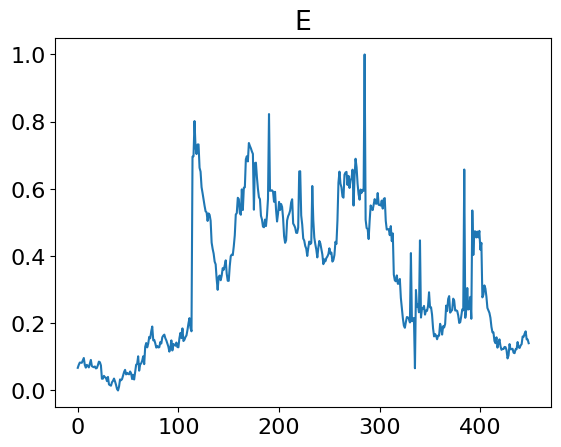

17021


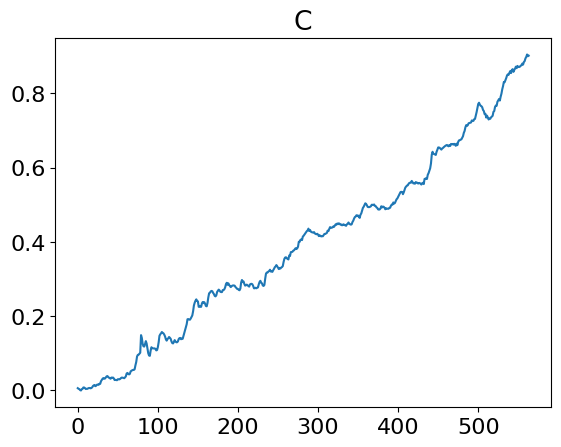

27108


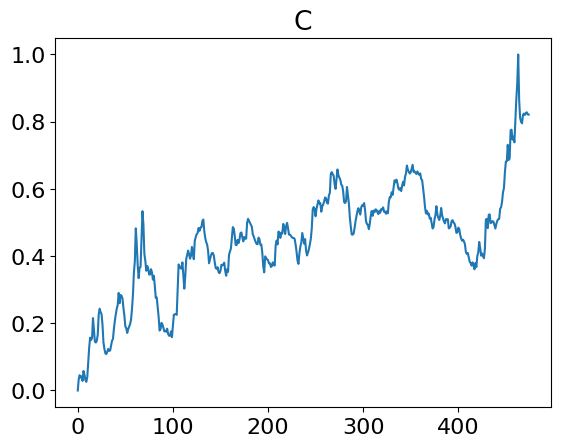

36030


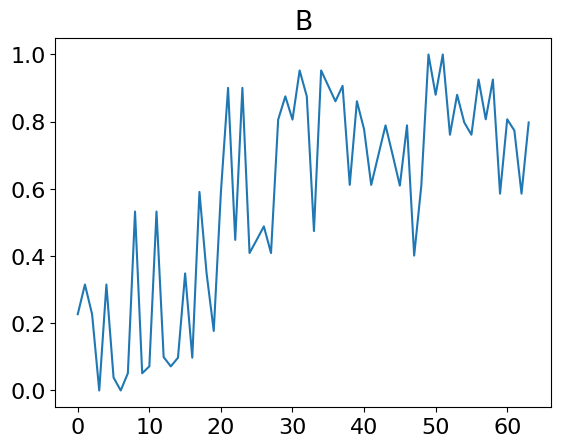

42694


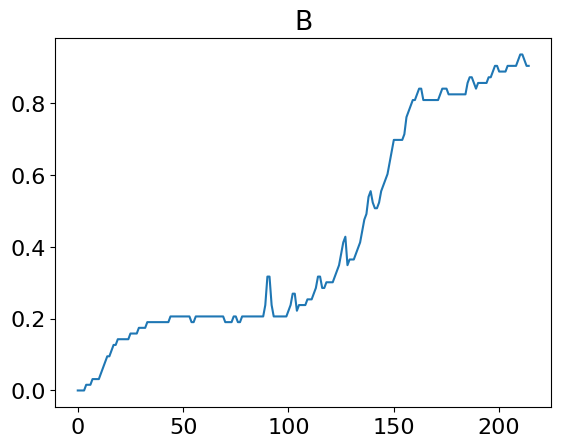

38940


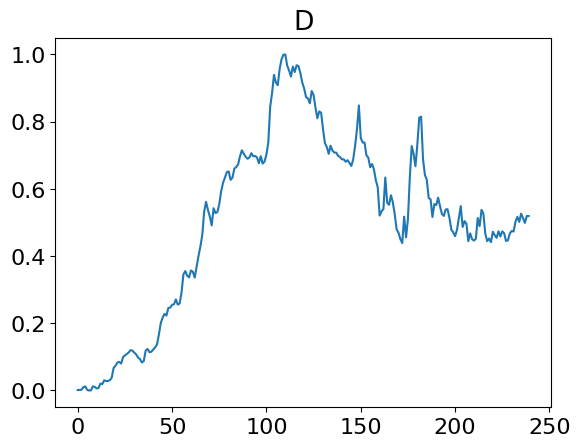

3131


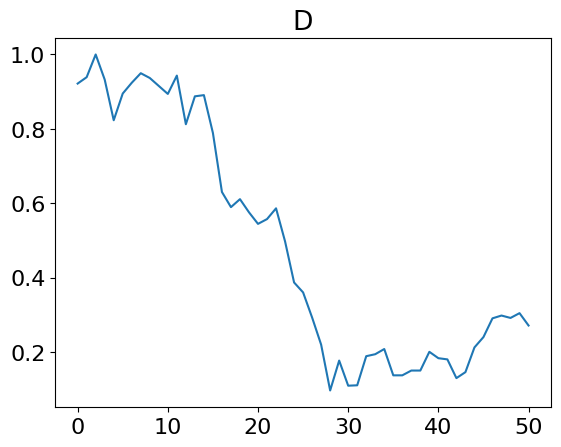

8670


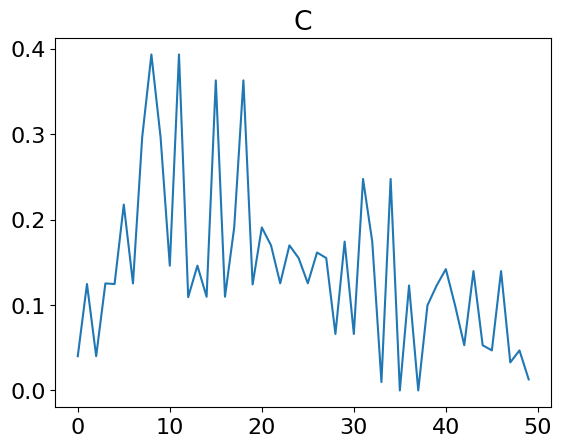

32200


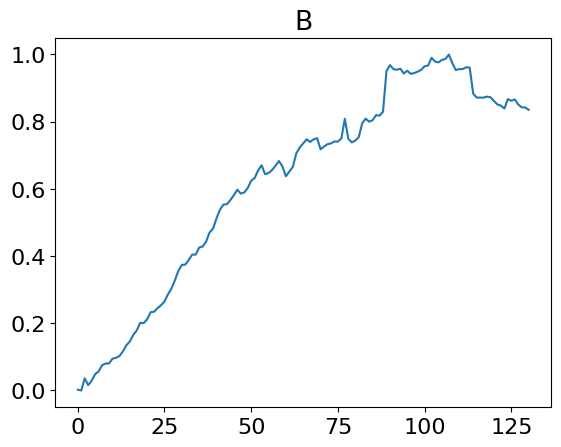

39272


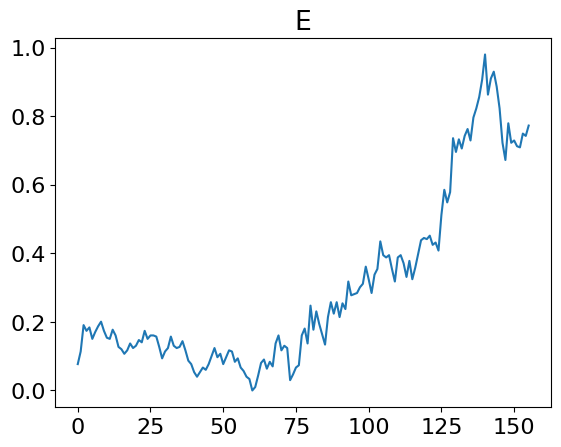

12888


In [4]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy')
valid_periods= np.load('valid_periods.npy')



for i in range(0,10):
  idx = np.random.randint(0,48000)
  a,b = valid_periods[idx,:]
  plt.plot(training_data[idx,a:b+1])
  plt.title(str(categories[idx]))
  plt.show()
  print(idx)





In [6]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

categories = np.array([mapping[element] for element in categories])


# Get unique elements and their counts
unique_elements, counts = np.unique(categories, return_counts=True)

# Print frequencies
for i, element in enumerate(unique_elements):
    print(f"Element: {element}, Frequency: {counts[i]*100/48000} % ")



Element: 0, Frequency: 11.933333333333334 % 
Element: 1, Frequency: 22.889583333333334 % 
Element: 2, Frequency: 20.86875 % 
Element: 3, Frequency: 20.866666666666667 % 
Element: 4, Frequency: 22.864583333333332 % 
Element: 5, Frequency: 0.5770833333333333 % 


### Trying interpolation for outliers and missing values

In [ ]:
# Interpolate to remove outliers and missing values

# for i in range(0,10):
#   idx = np.random.randint(0,48000)
#   a,b = valid_periods[idx,:]
#   time_serie_ex = training_data[idx,a:b+1]

#   time_serie_ex[time_serie_ex == 1] = np.nan
#   consecutive_indices = np.where(time_serie_ex[1:] == time_serie_ex[:-1])[0] + 1

#   # Mark the second occurrence of consecutive values as NaN
#   for idx in consecutive_indices:
#       time_serie_ex[idx] = np.nan
#   nan_indices = np.isnan(time_serie_ex)

#   interpolated_values = np.interp(np.arange(len(time_serie_ex)), np.where(~nan_indices)[0], time_serie_ex[~nan_indices])

#   plt.figure(figsize=(10, 6))
#   plt.plot(time_serie_ex, label='Original')
#   plt.plot(interpolated_values, label='Interpolated', linestyle='dashed')
#   plt.legend()
#   plt.xlabel('Time')
#   plt.ylabel('Normalized Values')
#   plt.title('Original and Interpolated Time Series')
#   plt.show()

In [5]:
# # Interpolate to remove outliers and missing value
# for i in range(0,len(training_data)):
#   a,b = valid_periods[i,:]
#   time_serie_i = training_data[i,a:b+1]

#   time_serie_i[time_serie_i == 1] = np.nan
#   consecutive_indices = np.where(time_serie_i[1:] == time_serie_i[:-1])[0] + 1

#   # Mark the second occurrence of consecutive values as NaN
#   for idx in consecutive_indices:
#       time_serie_i[idx] = np.nan

#   nan_indices = np.isnan(time_serie_i) # index of outliers and missing value

#   interpolated_values = np.interp(np.arange(len(time_serie_i)), np.where(~nan_indices)[0], time_serie_i[~nan_indices])

#   training_data[i,a:b+1] = interpolated_values


### Add data + Separate data

In [7]:
def split_sequence_1(sequence, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(0,len(sequence),n_steps_out):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
  if out_end_ix > len(sequence):
    break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)


In [8]:
def split_sequence_2(sequence, n_steps_in, n_steps_out): # Add the padding at the beggining if the time serie is too short
 X, y = list(), list()

 if len(sequence) < n_steps_in + n_steps_out: # If time serie is too short
  # Calculate the number of zeros to pad
  pad_length = n_steps_in + n_steps_out - len(sequence)
  # Pad zeros at the beginning of the sequence
  sequence = np.pad(sequence, (pad_length, 0), mode='constant')
  x_el = sequence[0:n_steps_in]
  y_el = sequence[-n_steps_out:]
  X.append(x_el)
  y.append(y_el)

 else :
  for i in range(0,len(sequence),n_steps_out):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)

 return np.array(X), np.array(y)


In [9]:
category_data = {category: [] for category in np.unique(categories)}

# trans = RobustScaler()
too_short = 0

window = 120
telescope = 18
for i, category in enumerate(categories):
    a,b = valid_periods[i,:]
    x,y = split_sequence_1(training_data[i,a:b],window,telescope)
    if len(x) == 0 :
      too_short = too_short + 1
      continue
    for j in range(len(x)):
      xy = np.concatenate((x[j], y[j]), axis = 0 )
      # xy = np.reshape(xy, (-1,1))
      # xy = trans.fit_transform(xy)
      # xy = np.reshape(xy, (1,209))
      category_data[category].append(xy)

random.shuffle(category_data[0])
random.shuffle(category_data[1])
random.shuffle(category_data[2])
random.shuffle(category_data[3])
random.shuffle(category_data[4])
random.shuffle(category_data[5])

# Tryining to rebalance the categories
# category_data[0] = category_data[0][::3]
# category_data[1] = category_data[1][::3]
# category_data[2] = category_data[2][::3]
# category_data[3] = category_data[3][::3]
# category_data[4] = category_data[4][::3]
# category_data[5] = [item for item in category_data[5] for _ in range(10)]



print(len(category_data[0]))
print(len(category_data[1]))
print(len(category_data[2]))
print(len(category_data[3]))
print(len(category_data[4]))
print(len(category_data[5]))



X_training =[]
X_valid = []
ratio = 0.8

for i in range(0,6):
  size_train = np.floor(ratio * len(category_data[i]))
  size_val = len(category_data[i]) - size_train
  x_training = category_data[i][0:int(size_train)]
  x_valid = category_data[i][-int(size_val):]
  X_training = X_training + x_training
  X_valid = X_valid + x_valid


random.shuffle(X_training)
random.shuffle(X_valid)
X_training = np.reshape(X_training, (-1,window+telescope))
X_valid = np.reshape(X_valid, (-1,window+telescope))
# X_training = trans.fit_transform(X_training)
# X_valid = trans.fit_transform(X_valid)

del category_data

X_train, y_train = X_training[:,:window], X_training[:,-telescope:]
X_val, y_val = X_valid[:,:window], X_valid[:,-telescope:]

# transformer_x = RobustScaler().fit(X_train)
# transformer_y = RobustScaler().fit(y_train)
# X_train = transformer_x.transform(X_train)
# y_train = transformer_y.transform(y_train)
# X_val = transformer_x.transform(X_val)
# y_val = transformer_y.transform(y_val)

X_train = np.expand_dims(X_train,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)
y_train = np.expand_dims(y_train,axis = -1)
y_val = np.expand_dims(y_val,axis = -1)





48106
39616
54241
62424
42972
1373
No NaN values found in the array.


### Define model

In [10]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]


print(input_shape,output_shape)


(120, 1) (18, 1)


In [ ]:
def build_LSTM_model_Bidirectional_with_Attention(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    # x = tfkl.Masking(mask_value=0.,input_shape=(window, 1))(input_layer)  # Added

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    attention = tfkl.Attention()([x,x])
    attention_result = tfkl.Concatenate()([x,attention])

    x = tfkl.Flatten()(attention_result)

    output_layer = tfkl.Dense(output_shape[0], activation = 'sigmoid', name = 'dense_output')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [11]:
def build_encod_decod_model_LSTM_2(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    # First one
    x1 = tfkl.LSTM(64, activation='relu', return_sequences=True)(input_layer) # mettre stateful = True
    x1 = tfkl.TimeDistributed(tfkl.Dense(1, activation='linear'))(x1)
    # Maybe add here a skip connection with input layer
    x = tfkl.Add()([x1,input_layer])
    x1 = tfkl.ReLU()(x)

    # Second one
    x2 = tfkl.LSTM(64, activation='relu', return_sequences=True)(input_layer)
    attention = tfkl.Attention()([x2,x2])

    x = tfkl.Concatenate()([x1,attention])


    x = tfkl.Dense(32, activation='linear')(x)

    x = tfkl.Flatten()(x)


    output_layer = tfkl.Dense(output_shape[0], activation='sigmoid')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Encod_Decod_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

Model: "Encod_Decod_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 120, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 120, 64)              16896     ['input_layer[0][0]']         
                                                                                                  
 time_distributed (TimeDist  (None, 120, 1)               65        ['lstm[0][0]']                
 ributed)                                                                                         
                                                                                                  
 add (Add)                   (None, 120, 1)               0         ['time_di

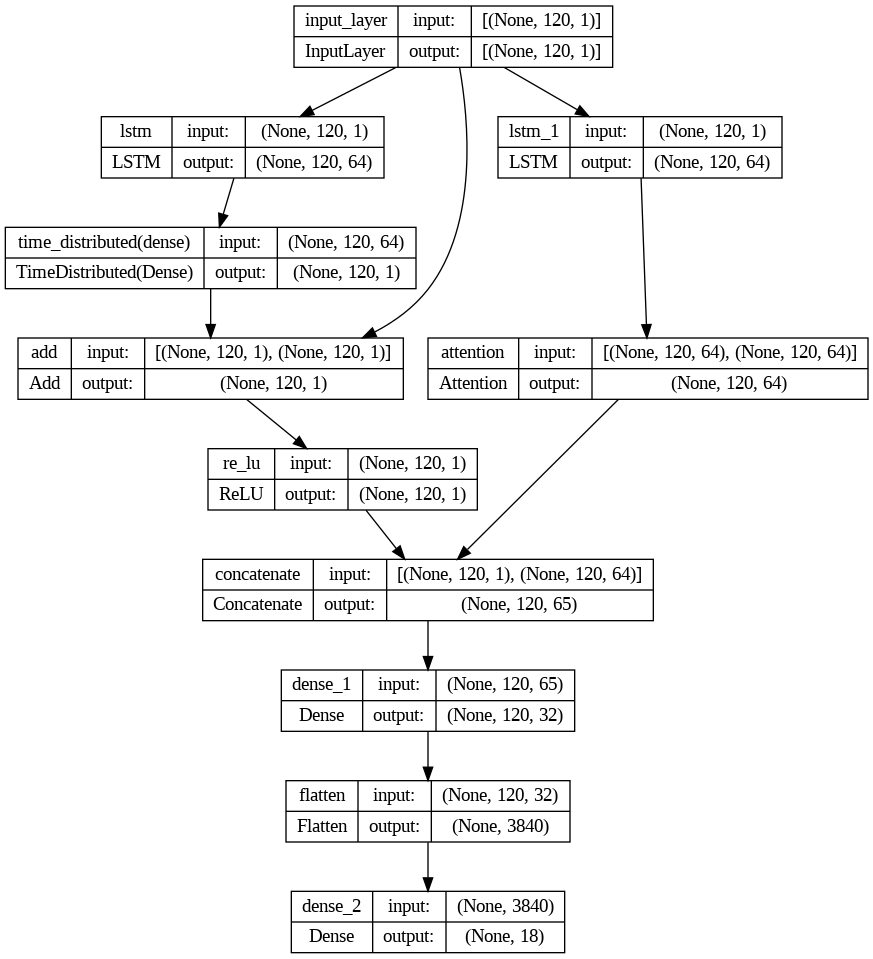

In [12]:
model = build_encod_decod_model_LSTM_2(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [13]:
batch_size = 128
epochs = 200

In [14]:
#Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-6)
    ]
).history


Epoch 1/200
1555/1555 [==============================] - 483s 307ms/step - loss: 0.0125 - val_loss: 0.0110 - lr: 0.0010
Epoch 2/200
1555/1555 [==============================] - 475s 306ms/step - loss: 0.0108 - val_loss: 0.0107 - lr: 0.0010
Epoch 3/200
1555/1555 [==============================] - 472s 304ms/step - loss: 0.0106 - val_loss: 0.0106 - lr: 0.0010
Epoch 4/200
1555/1555 [==============================] - 476s 306ms/step - loss: 0.0104 - val_loss: 0.0107 - lr: 0.0010
Epoch 5/200
1555/1555 [==============================] - 474s 305ms/step - loss: 0.0101 - val_loss: 0.0102 - lr: 1.0000e-04
Epoch 6/200
1555/1555 [==============================] - 475s 306ms/step - loss: 0.0101 - val_loss: 0.0101 - lr: 1.0000e-04
Epoch 7/200
1555/1555 [==============================] - 483s 311ms/step - loss: 0.0100 - val_loss: 0.0101 - lr: 1.0000e-04
Epoch 8/200
1555/1555 [==============================] - 472s 304ms/step - loss: 0.0100 - val_loss: 0.0101 - lr: 1.0000e-05
Epoch 9/200
1555/1555 [=

KeyboardInterrupt: ignored

In [15]:
# model.save('model_V4.2')

In [ ]:
# X = model.predict(X_val)